<a href="https://colab.research.google.com/github/TiaBerte/masked-face/blob/main/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import os

In [30]:
df = pd.DataFrame(columns=['Name', 'Ethnicity'])
path = './dataset/test/'
celeb_list = os.listdir(path)

for name in celeb_list:
    row = pd.DataFrame({'Name' : name}, index = [0])
    df = pd.concat([df, row])

In [29]:
df.to_csv('./ethnicity_test.csv', index=False)

In [3]:
pairs = 'C:/Users/Mattia/Desktop/MLFW/pairs.txt'
with open(pairs, 'r') as f:
    p = f.readlines()

In [2]:
import pandas as pd
df = pd.read_csv('ethnicity_test.csv')

In [21]:
df[df['ethnicity'] == 'Brendan_Gaughan']

,Name,Skin_B,Skin_G,Skin_R,ethnicity


In [6]:
grouped = df.groupby(by='Ethnicity').count()/294*100

grouped

,Name
Ethnicity,
Afroamerican,7.482993
Arab,6.122449
Asiatic,5.442177
Hispanic,8.163265
White,72.789116


AttributeError: module 'numpy' has no attribute 'matrix'

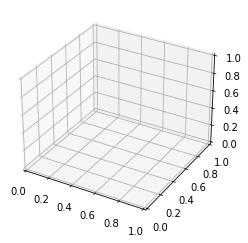

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('ethnicity.csv')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(df)):
    x = df['Skin_B'].iloc[i]
    y = df['Skin_G'].iloc[i]
    z = df['Skin_R'].iloc[i]
    ax.scatter(x, y, z)

In [34]:
df.head(8)
len(df)

2386

In [29]:
df = df.dropna()
len(df)

8698

In [31]:
grouped = df.groupby(by='Name').mean().reset_index()
grouped.head()

,Name,Skin_B,Skin_G,Skin_R
0,AJ_Lamas,129.085133,157.385524,197.401812
1,Aaron_Eckhart,112.070054,131.937383,174.103971
2,Aaron_Guiel,115.627017,132.213654,177.165214
3,Aaron_Peirsol,139.197227,161.051394,212.479727
4,Aaron_Sorkin,76.050987,94.290196,153.007661


In [32]:
len(grouped)

2386

In [13]:
df['Skin'].apply(lambda r : tuple(r['Skin_B'], r['Skin_G'], r['Skin_R']))

KeyError: 'Skin'

In [ ]:
!sudo apt-get install git-lfs
!git-lfs clone https://github.com/TiaBerte/masked-face.git
%cd masked-face

In [1]:
import torch
import torchvision
from torchvision import transforms
from barlowTwins import BarlowTwins
from utils import adjust_learning_rate, load_state_dict, get_mean_and_std, LARS
from pathlib import Path
import argparse
import json
import sys
import time
from torch import nn
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from tqdm import tqdm

In [4]:
from dataload import MaskedFaceDataset
import argparse

path = './dataset/'
train_path = path + 'train/'
val_path = path + 'val/'

train_set = MaskedFaceDataset(train_path)
val_set = MaskedFaceDataset(val_path)

num_workers = 2
size_batch_train = 64
size_batch_val = 2 * size_batch_train

loader_train = DataLoader(train_set, batch_size=size_batch_train, 
                                           shuffle=True, 
                                           pin_memory=True, 
                                           num_workers=num_workers)

loader_val = DataLoader(val_set, batch_size=size_batch_val, 
                                         shuffle=False,
                                         num_workers=num_workers)




In [7]:
"""Train = 2397
val = 300
Test = 300
"""

N_IDENTITY = 8631
PATH = './'
model = resnet50(num_classes=N_IDENTITY)#False)
load_state_dict(model, PATH+'weights/resnet50_ft_weight.pkl')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device=device)




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**PARSER**

In [10]:
from pathlib import Path

def get_args_parser():
    
    parser = argparse.ArgumentParser(description='Barlow Twins Training')
    #parser.add_argument('data', type=Path, metavar='DIR',
    #                help='path to dataset')
    parser.add_argument('--workers', default=8, type=int, metavar='N',
                    help='number of data loader workers')
    parser.add_argument('--epochs', default=1000, type=int, metavar='N',
                    help='number of total epochs to run')
    parser.add_argument('--batch-size', default=2048, type=int, metavar='N',
                    help='mini-batch size')
    parser.add_argument('--learning-rate-weights', default=0.2, type=float, metavar='LR',
                    help='base learning rate for weights')
    parser.add_argument('--learning-rate-biases', default=0.0048, type=float, metavar='LR',
                    help='base learning rate for biases and batch norm parameters')
    parser.add_argument('--weight-decay', default=1e-6, type=float, metavar='W',
                    help='weight decay')
    parser.add_argument('--lambd', default=0.0051, type=float, metavar='L',
                    help='weight on off-diagonal terms')
    parser.add_argument('--projector', default='8192-8192-8192', type=str)
                    #metavar='MLP', help='projector MLP')
    parser.add_argument('--print-freq', default=100, type=int, metavar='N',
                    help='print frequency')
    parser.add_argument('--checkpoint-dir', default='./checkpoint/', type=Path,
                    metavar='DIR', help='path to checkpoint directory')
    parser.add_argument('--backbone_lr', default=0, type=float, 
                    help='Learning rate used for fine tuning the backbone, disabled by default')

    return parser


def main_worker(args):
    PATH = './'
    
    model = BarlowTwins(args)
    load_state_dict(model, PATH+'weights/resnet50_ft_weight.pkl')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device=device)

    param_weights = []
    param_biases = []
    for param in model.parameters():
        if param.ndim == 1:
            param_biases.append(param)
        else:
            param_weights.append(param)

    parameters = [{'params': param_weights}, {'params': param_biases}]

    optimizer = LARS(parameters, lr=0.001, weight_decay=args.weight_decay,
                     weight_decay_filter=True,
                     lars_adaptation_filter=True)

    # automatically resume from checkpoint if it exists
    if (args.checkpoint_dir / 'checkpoint.pth').is_file():
        ckpt = torch.load(args.checkpoint_dir / 'checkpoint.pth',
                          map_location='cpu')
        start_epoch = ckpt['epoch']
        model.load_state_dict(ckpt['model'])
        optimizer.load_state_dict(ckpt['optimizer'])
    else:
        start_epoch = 0

    start_time = time.time()
    scaler = torch.cuda.amp.GradScaler()
    step = 0
    for epoch in range(start_epoch, args.epochs):
        #for step, ((y1, y2), _) in enumerate(loader_train, start=epoch * len(loader_train)):
        data_bar = tqdm(loader_train, desc=f"Train Epoch {epoch}")
        for img_1, img_2 in data_bar:
            step += 1
            #y1 = y1.cuda(gpu, non_blocking=True)
            #y2 = y2.cuda(gpu, non_blocking=True)
            adjust_learning_rate(args, optimizer, loader_train, step)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                loss = model.forward(img_1, img_2)
            
            optimizer.step()
            #scaler.scale(loss).backward()
            #scaler.step(optimizer)
            #scaler.update()
            if step % args.print_freq == 0:
                if args.rank == 0:
                    stats = dict(epoch=epoch, step=step,
                                 lr_weights=optimizer.param_groups[0]['lr'],
                                 lr_biases=optimizer.param_groups[1]['lr'],
                                 loss=loss.item(),
                                 time=int(time.time() - start_time))
                    print(json.dumps(stats))
        if args.rank == 0:
            # save checkpoint
            state = dict(epoch=epoch + 1, model=model.state_dict(),
                         optimizer=optimizer.state_dict())
            torch.save(state, args.checkpoint_dir / 'checkpoint.pth')
    if args.rank == 0:
        # save final model
        torch.save(model.module.backbone.state_dict(),
                   args.checkpoint_dir / 'resnet50.pth')






In [11]:
from barlowTwins import BarlowTwins

PATH = './'
args_parser = get_args_parser()
args = args_parser.parse_args([])

model = BarlowTwins(args)
load_state_dict(model, PATH+'weights/resnet50_ft_weight.pkl')
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device=device)

param_weights = []
param_biases = []
for param in model.parameters():
        if param.ndim == 1:
            param_biases.append(param)
        else:
            param_weights.append(param)

parameters = [{'params': param_weights}, {'params': param_biases}]
    
optimizer = LARS(parameters, lr=0.001, weight_decay=args.weight_decay,
                     weight_decay_filter=True,
                     lars_adaptation_filter=True)

    # automatically resume from checkpoint if it exists
if (args.checkpoint_dir / 'checkpoint.pth').is_file():
        ckpt = torch.load(args.checkpoint_dir / 'checkpoint.pth',
                          map_location='cpu')
        start_epoch = ckpt['epoch']
        model.load_state_dict(ckpt['model'])
        optimizer.load_state_dict(ckpt['optimizer'])
else:
        start_epoch = 0

start_time = time.time()
#scaler = torch.cuda.amp.GradScaler()
step = 0
for epoch in range(start_epoch, args.epochs):
        #for step, ((y1, y2), _) in enumerate(loader_train, start=epoch * len(loader_train)):
        data_bar = tqdm(loader_train, desc=f"Train Epoch {epoch}")
        for img_1, img_2 in data_bar:
            step += 1
            #y1 = y1.cuda(gpu, non_blocking=True)
            #y2 = y2.cuda(gpu, non_blocking=True)
            adjust_learning_rate(args, optimizer, loader_train, step)
            optimizer.zero_grad()
            #with torch.cuda.amp.autocast():
            loss = model.forward(img_1, img_2)
            #scaler.scale(loss).backward()
            loss.backward()
            scaler.step(optimizer)
            scaler.update()
            if step % args.print_freq == 0:
                if args.rank == 0:
                    stats = dict(epoch=epoch, step=step,
                                 lr_weights=optimizer.param_groups[0]['lr'],
                                 lr_biases=optimizer.param_groups[1]['lr'],
                                 loss=loss.item(),
                                 time=int(time.time() - start_time))
                    print(json.dumps(stats))
        if args.rank == 0:
            # save checkpoint
            state = dict(epoch=epoch + 1, model=model.state_dict(),
                         optimizer=optimizer.state_dict())
            torch.save(state, args.checkpoint_dir / 'checkpoint.pth')
if args.rank == 0:
        # save final model
        torch.save(model.module.backbone.state_dict(),
                   args.checkpoint_dir / 'resnet50.pth')


Train Epoch 0:   0%|          | 0/38 [00:00<?, ?it/s]

In [47]:
import pickle
with open(PATH+'weights/resnet50_ft_weight.pkl', 'rb') as f:  
      obj = f.read()

weights = {key: torch.from_numpy(arr) for key, arr in pickle.loads(obj, encoding='latin1').items()}
model.backbone.load_state_dict(weights)

RuntimeError: Error(s) in loading state_dict for ResNet:
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 

In [40]:
args_parser = get_args_parser()
args = args_parser.parse_args([])

In [43]:
main_worker(args)

KeyError: 'unexpected key "layer4.1.bn3.bias" in state_dict'